In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('./Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [3]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


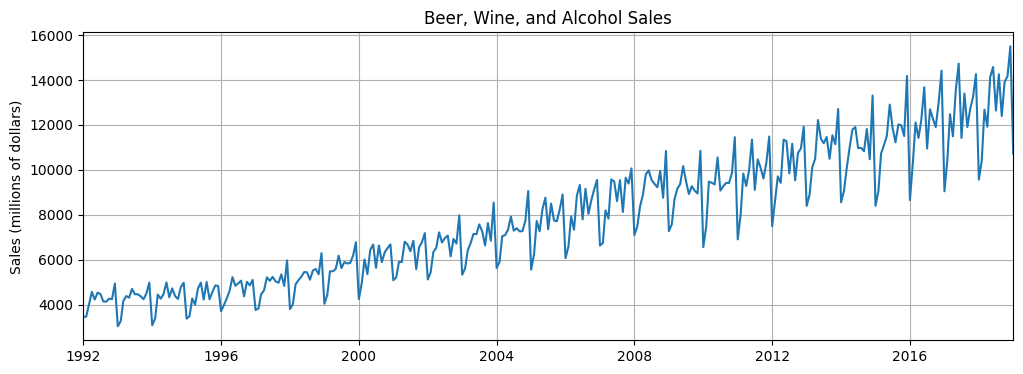

In [6]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [7]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [11]:
train_norm.min()

-1.0

In [12]:
train_norm.max()

1.0

In [13]:
train_norm.mean()

-0.2041940178388313

In [14]:
type(train_norm)

numpy.ndarray

In [15]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [16]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [17]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [18]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [20]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25310215
Epoch:  2 Loss: 0.37531969
Epoch:  3 Loss: 0.39027238
Epoch:  4 Loss: 0.34934661
Epoch:  5 Loss: 0.33085656
Epoch:  6 Loss: 0.33229983
Epoch:  7 Loss: 0.32670370
Epoch:  8 Loss: 0.32074124
Epoch:  9 Loss: 0.30653548
Epoch: 10 Loss: 0.29518029
Epoch: 11 Loss: 0.26934317
Epoch: 12 Loss: 0.25998449
Epoch: 13 Loss: 0.24665916
Epoch: 14 Loss: 0.22404043
Epoch: 15 Loss: 0.18602757
Epoch: 16 Loss: 0.18561082
Epoch: 17 Loss: 0.17208986
Epoch: 18 Loss: 0.25158119
Epoch: 19 Loss: 0.22556792
Epoch: 20 Loss: 0.17438360
Epoch: 21 Loss: 0.20225847
Epoch: 22 Loss: 0.20846863
Epoch: 23 Loss: 0.16678396
Epoch: 24 Loss: 0.17547260
Epoch: 25 Loss: 0.12010290
Epoch: 26 Loss: 0.08638449
Epoch: 27 Loss: 0.03181576
Epoch: 28 Loss: 0.01344702
Epoch: 29 Loss: 0.08735292
Epoch: 30 Loss: 0.00212247
Epoch: 31 Loss: 0.01755061
Epoch: 32 Loss: 0.00550368
Epoch: 33 Loss: 0.00547082
Epoch: 34 Loss: 0.01774462
Epoch: 35 Loss: 0.03691229
Epoch: 36 Loss: 0.01467209
Epoch: 37 Loss: 0.00564271
E

In [21]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [22]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.1961873173713684,
 0.7666499018669128,
 0.3513656556606293,
 0.8196238875389099,
 0.9009762406349182,
 0.4399895668029785,
 0.9122187495231628,
 0.5397804379463196,
 0.7170401215553284,
 0.641906201839447,
 0.6747800707817078,
 0.2358541041612625]

In [23]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10028.09771296],
       [13365.01860097],
       [10935.81340279],
       [13674.88993016],
       [14150.76051959],
       [11454.21897101],
       [14216.52357534],
       [12037.94567177],
       [13074.82619104],
       [12635.33032766],
       [12827.62602404],
       [10260.12858229]])

In [24]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [25]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

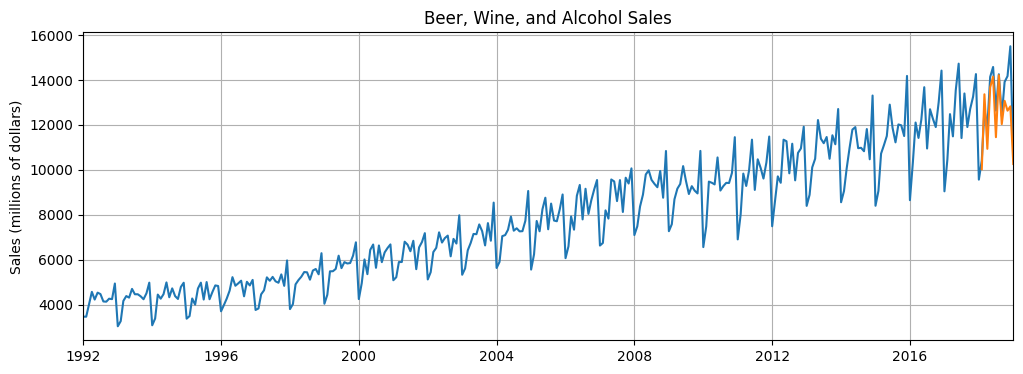

In [26]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

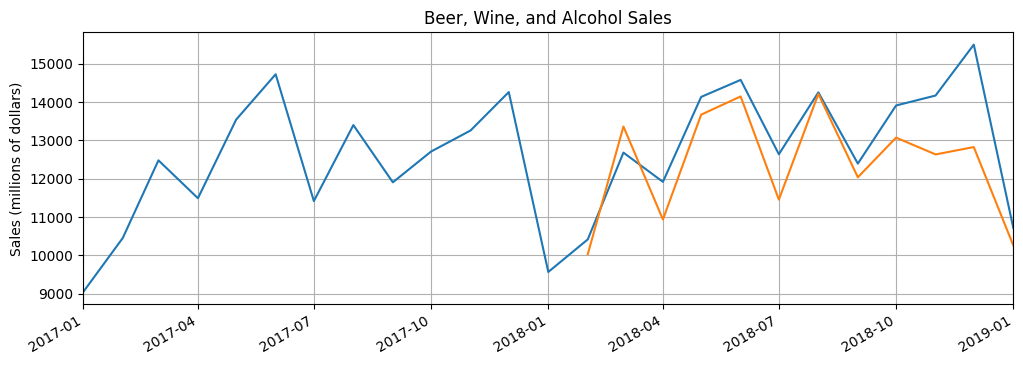

In [27]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [28]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01404137
Epoch:  2 Loss: 0.02066611
Epoch:  3 Loss: 0.01307132
Epoch:  4 Loss: 0.01613684
Epoch:  5 Loss: 0.01666697
Epoch:  6 Loss: 0.01745484
Epoch:  7 Loss: 0.01699012
Epoch:  8 Loss: 0.01912845
Epoch:  9 Loss: 0.01533153
Epoch: 10 Loss: 0.01254362
Epoch: 11 Loss: 0.01071472
Epoch: 12 Loss: 0.00645624
Epoch: 13 Loss: 0.00664429
Epoch: 14 Loss: 0.00664230
Epoch: 15 Loss: 0.01092365
Epoch: 16 Loss: 0.00303229
Epoch: 17 Loss: 0.00379601
Epoch: 18 Loss: 0.00548060
Epoch: 19 Loss: 0.00463663
Epoch: 20 Loss: 0.00399396
Epoch: 21 Loss: 0.00186147
Epoch: 22 Loss: 0.00164000
Epoch: 23 Loss: 0.00281368
Epoch: 24 Loss: 0.00309887
Epoch: 25 Loss: 0.00526998
Epoch: 26 Loss: 0.00364186
Epoch: 27 Loss: 0.00200665
Epoch: 28 Loss: 0.00147516
Epoch: 29 Loss: 0.00503430
Epoch: 30 Loss: 0.00041118
Epoch: 31 Loss: 0.00079957
Epoch: 32 Loss: 0.00049174
Epoch: 33 Loss: 0.00047220
Epoch: 34 Loss: 0.00033390
Epoch: 35 Loss: 0.00171394
Epoch: 36 Loss: 0.00524943
Epoch: 37 Loss: 0.00271385
E

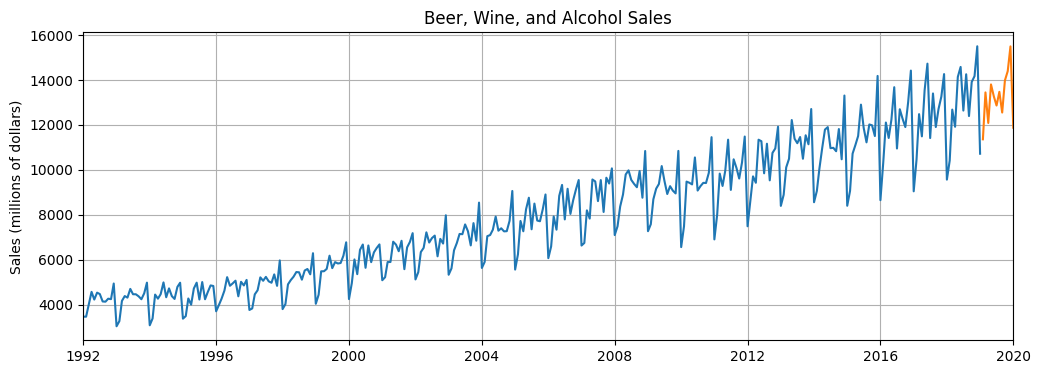

In [29]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()